In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from sklearn.utils import shuffle

train_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Applications/Training'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Applications/Testing'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+'/'+label):
        train_paths.append(train_dir+'/'+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+'/'+label):
        test_paths.append(test_dir+'/'+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [ ]:
import cv2
from PIL import Image
import numpy as np
import os

df = []
label = []
img_size = 128

for label_name in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label_name)
    for img_name in os.listdir(label_dir):
        if os.path.splitext(img_name)[1] == '.jpg':
            image = cv2.imread(os.path.join(label_dir, img_name))
            # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = Image.fromarray(image)
            image = image.resize((img_size,img_size))
            df.append(np.array(image))
            label.append(label_name)

df = np.array(df)
label = np.array(label)

print(df.shape)
print(label.shape)

(5712, 128, 128, 3)
(5712,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import normalize

X_train_normalized = normalize(X_train, axis=1)
X_test_normalized = normalize(X_test, axis=1)

In [ ]:
# mapping the class label

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
y_train_encoded = ohe.fit_transform(y_train.reshape(-1,1)).toarray()
y_test_encoded = ohe.fit_transform(y_test.reshape(-1,1)).toarray()

# Ensemble Model


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from keras.optimizers import Adam

class MyModel1:
    def __init__(self, layer_1, layer_2, layer_3, layer_4, learning_rate=0.0001, activation='relu'):
      super(MyModel1, self).__init__()
      self.layer_1 = layer_1
      self.layer_2 = layer_2
      self.layer_3 = layer_3
      self.layer_4 = layer_4
      self.learning_rate = learning_rate
      self.activation = activation
      self.model = self._build_model()

    def _build_model(self):
      tf.random.set_seed(42)
      model = tf.keras.models.Sequential([
          tf.keras.layers.Flatten(input_shape=(img_size, img_size, 3)),
          tf.keras.layers.Dense(self.layer_1, activation=self.activation),
          tf.keras.layers.Dense(self.layer_2, activation=self.activation),
          tf.keras.layers.Dense(self.layer_3, activation=self.activation),
          tf.keras.layers.Dense(self.layer_4, activation=self.activation),
          tf.keras.layers.Dense(4, activation='softmax')
          ])
        
      model.compile(
            optimizer=tf.keras.optimizers.Adam(self.learning_rate),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.CategoricalAccuracy()],
            )
      return model

    def train_model(self, X_train_normalized, y_train_encoded, epochs=15):
      self.model.fit(
          x=X_train_normalized,
          y=y_train_encoded,
          epochs=epochs,
          )
      
    def evaluate(self, X_test_normalized, y_test_encoded):
      return self.model.evaluate(X_test_normalized, y_test_encoded, verbose=0)

    def summary(self):
      return self.model.summary()

    def save_model(self, path):
      self.model.save(path)

    def predict_on_batch(self, x):
      return self.model.predict_on_batch(x)

In [ ]:
class EnsembleModel:
    def __init__(self):
        self.models = []

    def add_model(self, model):
        self.models.append(model)

    def predict_on_batch(self, x):
        preds = [model.predict_on_batch(x) for model in self.models]
        return np.mean(preds, axis=0)

    def save_model(self, path):
        models_path = []
        for i, model in enumerate(self.models):
            model_path = f'{path}_{i}.h5'
            model.save(model_path)
            models_path.append(model_path)
        with open(f'{path}.json', 'w') as f:
            json.dump(models_path, f)

In [ ]:
# Train multiple instances of the model with different hyperparameters
model1 = MyModel1(layer_1=32, layer_2=64, layer_3=128, layer_4=96, learning_rate=0.0003, activation='relu')
model1.train_model(X_train_normalized, y_train_encoded)

# Save the model
model1.save_model('/content/drive/MyDrive/Colab Notebooks/Deep Learning Applications/models/my_model1.h5')

Epoch 1/15
143/143 [==============================] - 7s 35ms/step - loss: 0.7275 - categorical_accuracy: 0.7170
Epoch 2/15
143/143 [==============================] - 4s 25ms/step - loss: 0.3868 - categorical_accuracy: 0.8674
Epoch 3/15
143/143 [==============================] - 4s 25ms/step - loss: 0.3148 - categorical_accuracy: 0.8923
Epoch 4/15
143/143 [==============================] - 5s 34ms/step - loss: 0.2309 - categorical_accuracy: 0.9234
Epoch 5/15
143/143 [==============================] - 4s 30ms/step - loss: 0.2125 - categorical_accuracy: 0.9234
Epoch 6/15
143/143 [==============================] - 4s 26ms/step - loss: 0.1613 - categorical_accuracy: 0.9459
Epoch 7/15
143/143 [==============================] - 4s 25ms/step - loss: 0.1508 - categorical_accuracy: 0.9464
Epoch 8/15
143/143 [==============================] - 5s 33ms/step - loss: 0.1215 - categorical_accuracy: 0.9584
Epoch 9/15
143/143 [==============================] - 3s 23ms/step - loss: 0.0922 - categorical_

In [ ]:
# Load the model
from tensorflow.keras.models import load_model
model1 = load_model('/content/drive/MyDrive/Colab Notebooks/Deep Learning Applications/models/my_model1.h5')

In [ ]:

model2 = MyModel1(layer_1=64, layer_2=128, layer_3=256, layer_4=512, learning_rate=0.0005, activation='sigmoid')
model2.train_model(X_train_normalized, y_train_encoded)

# Save the model
model2.save_model('/content/drive/MyDrive/Colab Notebooks/Deep Learning Applications/models/my_model2.h5')

Epoch 1/15
143/143 [==============================] - 11s 64ms/step - loss: 1.3156 - categorical_accuracy: 0.3390
Epoch 2/15
143/143 [==============================] - 6s 45ms/step - loss: 0.8091 - categorical_accuracy: 0.6654
Epoch 3/15
143/143 [==============================] - 8s 57ms/step - loss: 0.4640 - categorical_accuracy: 0.8632
Epoch 4/15
143/143 [==============================] - 7s 46ms/step - loss: 0.3339 - categorical_accuracy: 0.8919
Epoch 5/15
143/143 [==============================] - 8s 58ms/step - loss: 0.2909 - categorical_accuracy: 0.9059
Epoch 6/15
143/143 [==============================] - 7s 47ms/step - loss: 0.2538 - categorical_accuracy: 0.9190
Epoch 7/15
143/143 [==============================] - 8s 56ms/step - loss: 0.1966 - categorical_accuracy: 0.9365
Epoch 8/15
143/143 [==============================] - 7s 48ms/step - loss: 0.1846 - categorical_accuracy: 0.9392
Epoch 9/15
143/143 [==============================] - 8s 57ms/step - loss: 0.1546 - categorical

In [ ]:
# Load the model
from tensorflow.keras.models import load_model
model2 = load_model('/content/drive/MyDrive/Colab Notebooks/Deep Learning Applications/models/my_model2.h5')

In [ ]:
model3 = MyModel1(layer_1=48, layer_2=64, layer_3=128, layer_4=112, learning_rate=0.0001, activation='LeakyReLU')
model3.train_model(X_train_normalized, y_train_encoded)

# Save the model
model3.save_model('/content/drive/MyDrive/Colab Notebooks/Deep Learning Applications/models/my_model3.h5')

Epoch 1/15
143/143 [==============================] - 6s 35ms/step - loss: 0.7767 - categorical_accuracy: 0.7190
Epoch 2/15
143/143 [==============================] - 5s 33ms/step - loss: 0.3980 - categorical_accuracy: 0.8674
Epoch 3/15
143/143 [==============================] - 6s 42ms/step - loss: 0.3219 - categorical_accuracy: 0.8912
Epoch 4/15
143/143 [==============================] - 5s 32ms/step - loss: 0.2504 - categorical_accuracy: 0.9155
Epoch 5/15
143/143 [==============================] - 5s 32ms/step - loss: 0.2240 - categorical_accuracy: 0.9221
Epoch 6/15
143/143 [==============================] - 6s 42ms/step - loss: 0.1947 - categorical_accuracy: 0.9328
Epoch 7/15
143/143 [==============================] - 5s 37ms/step - loss: 0.1566 - categorical_accuracy: 0.9488
Epoch 8/15
143/143 [==============================] - 6s 40ms/step - loss: 0.1371 - categorical_accuracy: 0.9549
Epoch 9/15
143/143 [==============================] - 5s 38ms/step - loss: 0.1046 - categorical_

In [ ]:
# Load the model
from tensorflow.keras.models import load_model
model3 = load_model('/content/drive/MyDrive/Colab Notebooks/Deep Learning Applications/models/my_model3.h5')

In [ ]:
# Create the ensemble model
ensemble_model = EnsembleModel()
ensemble_model.add_model(model1)
ensemble_model.add_model(model2)
ensemble_model.add_model(model3)

# Generate predictions for the test set using the ensemble model
ensemble_preds = ensemble_model.predict_on_batch(X_test_normalized)

# Evaluate the performance of the ensemble predictions
ensemble_acc = tf.keras.metrics.CategoricalAccuracy()(y_test_encoded, ensemble_preds).numpy()
print(f"Ensemble accuracy: {ensemble_acc:.4f}")

Ensemble accuracy: 0.9230


In [ ]:
# Calculate the loss on the test set for each individual model in the ensemble
model_losses = []
for model in ensemble_model.models:
    loss, _ = model.evaluate(X_test_normalized, y_test_encoded)
    model_losses.append(loss)

# Calculate the average loss across all models
ensemble_loss = np.mean(model_losses)
print(f"Ensemble loss: {ensemble_loss:.4f}")

36/36 [==============================] - 0s 9ms/step - loss: 0.2739 - categorical_accuracy: 0.9265
Ensemble loss: 0.3048


In [ ]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 32)                1572896   
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 96)                12384     
                                                                 
 dense_4 (Dense)             (None, 4)                 388       
                                                                 
Total params: 1,596,100
Trainable params: 1,596,100
Non-

# K-fold cross-validation

In [ ]:
import numpy as np
from sklearn.model_selection import KFold

# Define the K-fold cross-validation splits
kfold_splits = 5
kfold = KFold(n_splits=kfold_splits, shuffle=True, random_state=42)

# Define the hyperparameters for your model
epochs = 10

# Create an instance of your model
my_model = MyModel1(layer_1=128, layer_2=64, layer_3=32, layer_4=16, learning_rate=0.0003, activation='relu')

# Reshape X_train_normalized and X_test_normalized to match the input shape of the model
X_train_normalized = X_train_normalized.reshape(-1, img_size, img_size, 3)
X_test_normalized = X_test_normalized.reshape(-1, img_size, img_size, 3)

# Train and evaluate the model using K-fold cross-validation
for fold_index, (train_indices, test_indices) in enumerate(kfold.split(X_train_normalized)):
    print(f"Fold {fold_index+1}")
    X_train_kfold, X_test_kfold = X_train_normalized[train_indices], X_train_normalized[test_indices]
    y_train_kfold, y_test_kfold = y_train_encoded[train_indices], y_train_encoded[test_indices]
    my_model.train_model(X_train_kfold, y_train_kfold, epochs=epochs)
    test_loss, test_accuracy = my_model.evaluate(X_test_normalized, y_test_encoded)
    print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

In [ ]:
# Save the model
my_model.save_model('/content/drive/MyDrive/Colab Notebooks/Deep Learning Applications/models/kf_model.h5')

In [ ]:
# Load the model
from tensorflow.keras.models import load_model
model_kf = load_model('/content/drive/MyDrive/Colab Notebooks/Deep Learning Applications/models/kf_model.h5')

In [ ]:
# Evaluate the model on the entire test set
test_loss, test_accuracy = model_kf.evaluate(X_test_normalized, y_test_encoded)
print(f"Overall test loss: {test_loss}, Overall test accuracy: {test_accuracy}")

36/36 [==============================] - 2s 25ms/step - loss: 0.3838 - categorical_accuracy: 0.9291
Overall test loss: 0.38378530740737915, Overall test accuracy: 0.9291338324546814


# Using VGG16 pretrained model

In [ ]:
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img

# Get a list of the unique labels in the training directory
unique_labels = os.listdir(train_dir)

def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(img_size,img_size))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Function to encode labels as integers
def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

# Function to decode labels from integers back to original labels
def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

# Function to generate batches of data for training
def datagen(paths, labels, batch_size=12, epochs=1):
    # Loop over the number of epochs
    for _ in range(epochs):
        # Loop over the paths in batches
        for x in range(0, len(paths), batch_size):
            # Get a batch of paths, images, and labels
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            # Encode the labels as integers
            batch_labels = encode_label(batch_labels)
            # Yield the batch of images and labels
            yield batch_images, batch_labels

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential

image_size = 128

class VGG:
    def __init__(self, input_shape, unique_labels):
        self.base_model = self._build_base_model(input_shape)
        self._set_trainable_layers()
        self.model = self._build_model(unique_labels)

    def _build_base_model(self, input_shape):
        base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
        return base_model

    def _set_trainable_layers(self):
        for layer in self.base_model.layers:
            layer.trainable = False
        self.base_model.layers[-2].trainable = True
        self.base_model.layers[-3].trainable = True
        self.base_model.layers[-4].trainable = True

    def _build_model(self, unique_labels):
        
        model = Sequential()
        model.add(Input(shape=input_shape))
        model.add(self.base_model)
        model.add(Flatten())
        model.add(Dropout(0.3))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(len(unique_labels), activation='softmax'))

        model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])
        
        return model

if __name__ == '__main__':
  input_shape = (image_size, image_size, 3)
  vgg = VGG(input_shape=input_shape, unique_labels=unique_labels)
  vgg.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
Non

In [ ]:
batch_size = 32
steps = int(len(train_paths)/batch_size)
epochs = 5
history_vgg = vgg.model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

In [ ]:
# Save the model
vgg.model.save('/content/drive/MyDrive/Colab Notebooks/Deep Learning Applications/models/model_vgg.h5')

In [ ]:
# Load the model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Deep Learning Applications/models/model_vgg.h5')


batch_size = 32
steps = int(len(train_paths)/batch_size)
epochs = 5
history_vgg = vgg.model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
178/178 [==============================] - 1404s 8s/step - loss: 0.4481 - sparse_categorical_accuracy: 0.8269
Epoch 2/5
178/178 [==============================] - 1375s 8s/step - loss: 0.2301 - sparse_categorical_accuracy: 0.9160
Epoch 3/5
178/178 [==============================] - 1392s 8s/step - loss: 0.1527 - sparse_categorical_accuracy: 0.9415
Epoch 4/5
178/178 [==============================] - 1371s 8s/step - loss: 0.1073 - sparse_categorical_accuracy: 0.9618
Epoch 5/5
178/178 [==============================] - 1354s 8s/step - loss: 0.0813 - sparse_categorical_accuracy: 0.9718


In [ ]:
loss = history_vgg.history['loss'][-1]
accuracy = history_vgg.history['sparse_categorical_accuracy'][-1]

In [ ]:
loss

0.08133133500814438

In [ ]:
accuracy

0.9718309640884399

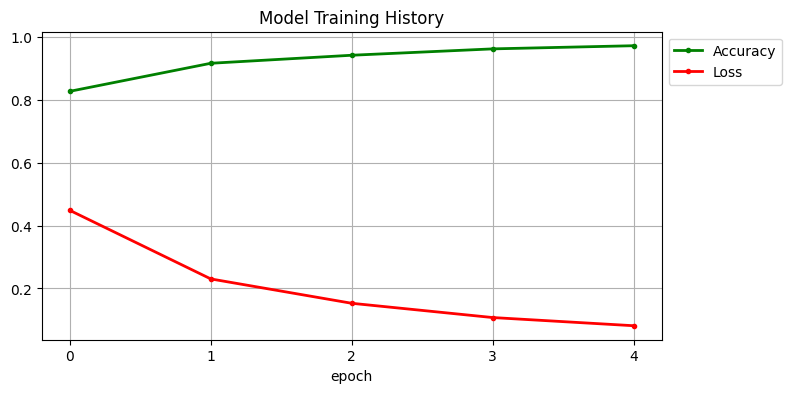

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history_vgg.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history_vgg.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Using Resnet 50 pretrained model

In [ ]:
from keras.applications import ResNet50V2
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D as GAP
from keras.models import Sequential

# defining the base pre-trained model
base_model = ResNet50V2(input_shape=(img_size, img_size, 3), include_top=False)
base_model.trainable = False

# defining our model
name = "ResNet50V2"
resnet = Sequential([
    base_model, 
    GAP(),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dense(len(unique_labels), activation='softmax'),
], name=name)

# compiling model
resnet.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 45
steps = int(len(train_paths)/batch_size)
epochs = 5

In [ ]:
# training model
history_resnet = resnet.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                     epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
126/126 [==============================] - 336s 3s/step - loss: 0.5158 - accuracy: 0.8277
Epoch 2/5
126/126 [==============================] - 328s 3s/step - loss: 0.2517 - accuracy: 0.9065
Epoch 3/5
126/126 [==============================] - 333s 3s/step - loss: 0.1708 - accuracy: 0.9365
Epoch 4/5
126/126 [==============================] - 333s 3s/step - loss: 0.1224 - accuracy: 0.9566
Epoch 5/5
126/126 [==============================] - 330s 3s/step - loss: 0.1014 - accuracy: 0.9633


In [ ]:
# Save the model
resnet.save('/content/drive/MyDrive/Colab Notebooks/Deep Learning Applications/models/model_resnet.h5')

In [ ]:
# Load the model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Deep Learning Applications/models/model_resnet.h5')

# # training model
# history = resnet.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
#                      epochs=epochs, steps_per_epoch=steps)

In [ ]:
loss = history_resnet.history['loss'][-1]
accuracy = history_resnet.history['accuracy'][-1]

In [ ]:
loss

0.10138130933046341

In [ ]:
accuracy

0.9632962942123413

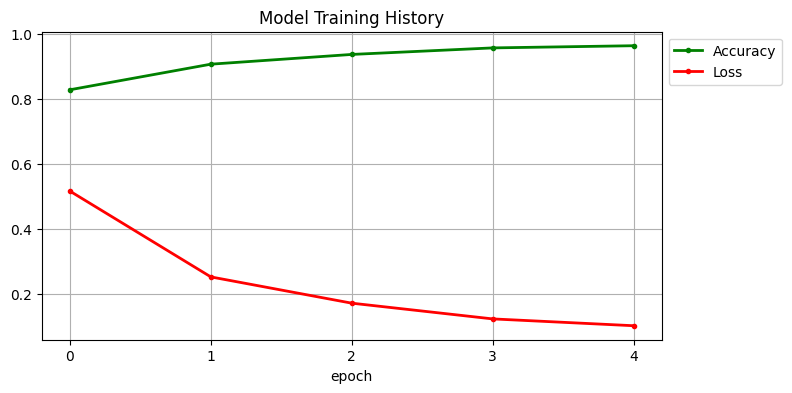

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history_resnet.history['accuracy'], '.g-', linewidth=2)
plt.plot(history_resnet.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()